# Scaling up Data Science Workflow/Pipeline with Ray Environment Through NOAA-GHCN Dataset

In this tutorial, we'll be using NumS, Modin, and Ray to show how we can ***scale*** dataframe manipulation and classical machine learning algorithms to analyze a big dataset, specifically the [NOAA Global Historical Climatology Network Daily (GHCN-D)](https://registry.opendata.aws/noaa-ghcn/) dataset where it containes over 200 years worth of historical weather data at a size of near 100 gigabytes.

Here are some brief descriptions of the libraries we will be focusing on:
* [Ray](https://github.com/ray-project/ray) - Ray is an open source library that can scale Python to distributed systems and offers an API that abstracts the distributed systems code to the developer. It serves as the core backend for NumS and Modin in this notebook. We will also be using it to scale Sklearn models by replacing joblib backend with a Ray backend. This will scale Sklearn models from single node to a cluster of nodes.
* [NumS](https://github.com/nums-project/nums) - NumS is an open source library that is an extension of the NumPy API that can scale numerical operations, abstracting distriubted systems architecture to the developer. It also offers generalized linear models for scalable models.
* [Modin](https://github.com/modin-project/modin): Modin is an open source library that is a drop-in replacement for Pandas that can scale up your dataframe mamipulation to distributed systems by changing a single line of code, also abstracting distributed systems architecture to the developer.

Once the autoscaler script has finished running and initialzing, we can start running cells to demonstrate the scalability. We'll show how scalability is abstracted to the user as well as the high interpretability we can gain from dataframe manipulations and hyperparameters of classical machine learning models. We'll also show what we can gain from the analysis and modeling of the dataset that could be helpful to climatologists. The purpose of this notebook is to showcase common data science techniques and workflow that will be easy to pick up on by developers and data scientists familiar with NumPy and Pandas when working with Big Data, where NumS and Modin serves as ***scalable*** replacements that are faithful to their original API counterparts.

We will split up the notebook into 5 main sections:
* Setting Up and Loading Datasets with Modin and S3
* Dataframe Manipulation and Cleaning with Modin
* Visualizations and Understanding the Data Through EDA
* Modeling Weather by Spatial Locality within Ray Environment (NumS, XGBoost, Sklearn)
* Modeling Weather by Temporal Locality with Time Series (NumS)

## Setting Up and Loading Datasets with Modin and S3
Here are the imports for our libraries. The main imports are NumS, Modin, Sklearn, and Ray.We will also use some additional machine learning and data science libraries to help with the full exploratory data analysis process. For certain packages, we will have to use intermediate calls to transform NumS and Modin data structures into the correct one (e.g. Sklearn only accepts NumPy arrays, Plotly can only accept Pandas dataframe). Fortunately, converting between NumS from/to NumPy and Modin from/to Pandas is easy.

The most important thing after setting up Ray is to make sure that the Ray Python library can also recognize and connect to the cluster setup, if there is one. Uncommenting the second line will enable single node setup, while uncommenting the third line will enable cluster setup. Additionally, the cell below where NumS cluster shape is configured will also confirm whether or not there are head and worker nodes.

By just changing one line of code of the Pandas import, we can automatically scale to multiple nodes! We can also scale NumPy API by just changing the import to NumS's extension of NumPy. Not all of the API functions are scaled for NumS and Modin, so some API functions that aren't scalable might fallback to their original counterpart (as indicated by a user warning). NumS and Modin are both open source, so we encourage users or developers to contribute in completing a full scalable API fitting their use case.

In [1]:
import ray
import os
ray.init(ignore_reinit_error=True, num_cpus=32, _temp_dir="/home/brian/external/aws-asdi/ray_temp"); # ray.init() config for single node setup
#ray.init(ignore_reinit_error=True, address="auto", _redis_password='5241590000000000'); # ray.init() config for cluster setup
import modin.pandas as pd
from nums import numpy as nps

from nums.core import settings
from nums.experimental.nums_modin import from_modin
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import warnings
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import gzip
import sys
#warnings.filterwarnings("ignore")

2021-09-17 17:04:47,641	INFO services.py:1265 -- View the Ray dashboard at http://127.0.0.1:8265


In [2]:
# NumS cluster setting
if len(ray.nodes()) > 1:
    settings.cluster_shape = (len(ray.nodes())-1, 1)
settings.cluster_shape

(1, 1)

Next, we will load some datasets to show how fast Modin compared to Pandas. Not only will we be comparing on a single node, but we will also show how much more speed you can achieve at scale in Modin to multiple nodes. 

Here are some benchmarks recorded on a single node:

**Modin**
```
CPU times: user 94.2 ms, sys: 31.1 ms, total: 125 ms
Wall time: 1.47 s
```
**Pandas**
```
CPU times: user 16 s, sys: 2.58 s, total: 18.6 s
Wall time: 18.3 s
```

Already, we see that Modin can effectively parallelize csv reads across multiple threads in a single node machine.

The times below are tested on a cluster setup of 1 head and 4 worker nodes:

**Modin**
```
CPU times: user 864 ms, sys: 202 ms, total: 1.07 s
Wall time: 820 ms
```

The speedups achieved when scaled to more nodes is even faster with over 20x performance! 

In [3]:
%%time
climate_2020 = pd.read_csv('data/2020.csv', header=None, names=["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"], quoting=3)
climate_2020["YEAR/MONTH/DAY"] = pd.to_datetime(climate_2020["YEAR/MONTH/DAY"], format="%Y%m%d")
climate_2020.head()

CPU times: user 306 ms, sys: 39.7 ms, total: 346 ms
Wall time: 1.91 s


,ID,YEAR/MONTH/DAY,ELEMENT,DATA VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME
0,AE000041196,2020-01-01,TMIN,168,NaN,NaN,S,NaN
1,AE000041196,2020-01-01,PRCP,0,D,NaN,S,NaN
2,AE000041196,2020-01-01,TAVG,211,H,NaN,S,NaN
3,AEM00041194,2020-01-01,PRCP,0,NaN,NaN,S,NaN
4,AEM00041194,2020-01-01,TAVG,217,H,NaN,S,NaN


Additionally, we can also directly download from public S3 bucket links. But given the connection speeds, performance may be inconsistent. It is reccomended to be near `us-east-1` server for as the public S3 bucket for NOAA GHCN-D dataset is located there.

Here are some benchmarks recorded on a single node:

**Modin**
```
CPU times: user 1.97 s, sys: 755 ms, total: 2.73 s
Wall time: 16 s
```

**Pandas**
```
CPU times: user 20.6 s, sys: 5.23 s, total: 25.9 s
Wall time: 52.9 s
```

The times below are tested on a cluster setup of 1 head and 4 worker nodes:

**Modin**
```
CPU times: user 8.47 s, sys: 3.15 s, total: 11.6 s
Wall time: 29.7 s
```

Again, performance is inconsistent due to it being loaded from public S3 buckets. But it is useful to see the convenience of loading directly from S3.

In [4]:
%%time
climate_2020 = pd.read_csv('s3://noaa-ghcn-pds/csv/2020.csv', header=None, names=["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"], quoting=3)
climate_2020["YEAR/MONTH/DAY"] = pd.to_datetime(climate_2020["YEAR/MONTH/DAY"], format="%Y%m%d")
climate_2020.head()

CPU times: user 1.52 s, sys: 323 ms, total: 1.85 s
Wall time: 12.2 s


,ID,YEAR/MONTH/DAY,ELEMENT,DATA VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME
0,AE000041196,2020-01-01,TMIN,168,NaN,NaN,S,NaN
1,AE000041196,2020-01-01,PRCP,0,D,NaN,S,NaN
2,AE000041196,2020-01-01,TAVG,211,H,NaN,S,NaN
3,AEM00041194,2020-01-01,PRCP,0,NaN,NaN,S,NaN
4,AEM00041194,2020-01-01,TAVG,217,H,NaN,S,NaN


## Dataframe Manipulation and Cleaning with Modin
Next, we will show how we can do dataframe manipulation to understand the data we are dealing with. We can download and load onto memory the NOAA GHCN-D dataset which containes over 200+ years worth of historical weather data. Data consists of `csv` files dating back to 1763, majority of logs containing temperature maximum, temperature minimum, precipitation, and snowfall. We can first start off by showing the inventory log of each station by reading `noaa-ghcn-pds/ghcnd-inventory.txt` directly from S3, showing the years of data as well as the element of weather a station has recorded.

Sources:
* [Data](https://registry.opendata.aws/noaa-ghcn/)
* [Documentation](https://registry.opendata.aws/noaa-ghcn/)

In [5]:
inventory = pd.read_fwf('s3://noaa-ghcn-pds/ghcnd-inventory.txt', widths=[12, 9, 10, 4, 5, 5], header=None, names=["ID", "LATITUDE", "LONGITUDE", "ELEMENT", "FIRSTYEAR", "LASTYEAR"])
inventory.head()

,ID,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949


We can also read `noaa-ghcn-pds/ghcnd-stations.txt` to output metadata for each station, such as elevation and the name of the station.

In [6]:
stations = pd.read_fwf('s3://noaa-ghcn-pds/ghcnd-stations.txt', widths=[12, 9, 10, 7, 3, 31, 4, 4, 6], header=None, names=["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSN FLAG", "HCN/CRN FLAG", "WMO ID"])
stations.head()

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
0,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
1,ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
2,AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
3,AEM00041194,25.2550,55.3640,10.4,NaN,DUBAI INTL,NaN,NaN,41194.0
4,AEM00041217,24.4330,54.6510,26.8,NaN,ABU DHABI INTL,NaN,NaN,41217.0


The ID per each station encodes its country in `noaa-ghcn-pds/ghcnd-countries.txt`. This will be useful later on if we want to do an analysis of data per country.

In [7]:
country_codes = pd.read_csv("s3://noaa-ghcn-pds/ghcnd-countries.txt", delimiter="\n", header=None)[0].str.extract('(?P<code>.{2})(?P<country>.{0,})')
country_codes.head()

To request implementation, send an email to feature_requests@modin.org.


,code,country
0,AC,Antigua and Barbuda
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Algeria
4,AJ,Azerbaijan


Here lies utility functions we will reuse throughout the notebook.

In [59]:
def df_loader(year, local=False):
    if local:
        df = pd.read_csv('data/' + str(year) + '.csv', header=None, names=["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"], quoting=3)
    else:
        df = pd.read_csv('s3://noaa-ghcn-pds/csv/' + str(year) + '.csv', header=None, names=["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"], quoting=3)
    df["YEAR/MONTH/DAY"] = pd.to_datetime(df["YEAR/MONTH/DAY"], format="%Y%m%d")
    return df

def df_filter(df, _id, element):
    return df.loc[(df["ID"] == _id) & (df["ELEMENT"] == element)][["YEAR/MONTH/DAY", "DATA VALUE"]].set_index("YEAR/MONTH/DAY").sort_index()

# Same as df_filter(), but a vector of ALL the data
def df_filter_vector(_id, element, local=False, custom_years=None):
    df_vector = pd.DataFrame(columns=["DATA VALUE"])
    if custom_years:
        years = range(custom_years[0], custom_years[1] + 1)
    for year in tqdm(years):
        if local:
            df = df_filter(dfs[year], _id, element)
        else:
            df = df_filter(df_loader(year), _id, element)
            
        if df_vector.empty:
            df_vector = df
        else:
            df_vector = df_vector.append(df)
    return df_vector

def rmse(actual, expected):
    """
    Computes the root mean squared error to evaluate models/predictions. It can accept all the datatypes used
    in this notebook
    """
    if type(actual) != type(expected):
        raise TypeError("actual and expected must be the same types")
    elif type(actual) == type(nps.array([])):
        return nps.sqrt(nps.mean((expected - actual) ** 2)).get()
    elif type(actual) == modin.pandas.dataframe.DataFrame or type(actual) == pandas.core.frame.DataFrame:
        raise NotImplementedError
    else:
        raise TypeError
        
def design_matrix(years, elements, target=None, convert_nps=False, local=False):
    """
    Set target to your "y" predictor. If y has NaNs or missing values, we will drop the data row.
    """
    df_design = pd.DataFrame()
    
    for year in tqdm(years):
        if local:
            df = dfs[year]
        else:
            df = df_loader(year)
            

        if target[0] not in df["ELEMENT"].unique():
            continue

        df = df[df['ELEMENT'].isin(elements)]
        df = pd.pivot_table(df, index=["ID", "YEAR/MONTH/DAY"], columns="ELEMENT", values="DATA VALUE").reset_index(level=[0,1])
        df = df.merge(stations[["ID", "LATITUDE", "LONGITUDE", "ELEVATION"]], how='inner', on='ID')
        
        if target:
            df = df.dropna(subset=target)
        df = df.dropna() #TODO add a flag to toggle this
        
        
        df["YEAR/MONTH/DAY"] = df["YEAR/MONTH/DAY"].apply(lambda x: pd.Period(x, freq='D').day_of_year)
        df["TMAX"] = df["TMAX"] / 10
        df["TMIN"] = df["TMIN"] / 10
        df["AVG"] = (df["TMAX"] + df["TMIN"]) / 2
        df["RANGE"] = df["TMAX"] - df["TMIN"]
        #df = df.drop(["ID"], axis=1)
        #df = df.astype(float)
        
        if df_design.empty:
            df_design = df
        else:
            df_design = df_design.append(df)
        
        
    
    if convert_nps:
        return nps.array(result.to_numpy().astype(np.double))
    return df_design

def design_matrix_time_series_stack(_id, element, years, convert_nps=True, local=False):
    """
    Inputs are station ID and element
    Output is a design matrix of time series per year stacked on top of each other.
    rows are year of data collected, 
    cols are day of the year
    
    returns NumS array or Pandas DataFrame
    """
    df_design = pd.DataFrame(columns=pd.date_range(start="2020-01-01", end="2020-12-31").strftime('%m-%d'))
    station_name = stations.loc[stations['ID'] == _id]["NAME"].item()
    
    for year in tqdm(years):
        if local:
            df = dfs[year]
        else:
            try:
                df = df_loader(year)
            except ClientError:
                tqdm.write(str(year) + ".csv doesn't exist on remote, addition to design matrix is skipped.")
                continue
            
        df = df_filter(df, _id, element)
        if df.empty:
            tqdm.write(element + " data on " + str(year) + " for " + station_name + " with id: " + _id + " is empty. Addition to design matrix is skipped.")
            continue
        df.index = df.index.strftime('%m-%d')
        df.columns = [year]
        df = df.T
        df_design = df_design.append(df)


    df_design.index.name = None
    df_design = df_design.astype('float64')
    if convert_nps:
        #return nums_modin.from_modin(df_design) # Experimental version has some bugs, use manual conversion for now
        return from_modin(df_design)
    return df_design

# Shuffles and splits design matrix into training and test set
def design_matrix_to_train_test(data, threshold=0.8, convert_nps=True):
    import random
    ids = list(data["ID"].unique())
    random.shuffle(ids)
    
    split = int(len(ids) * threshold) #Split 80:20
    train_ids = ids[:split]
    test_ids = ids[split:]
    
    train = data[data["ID"].isin(train_ids)]
    test = data[data["ID"].isin(test_ids)]
    
    train = data[data["ID"].isin(train_ids)]
    test = data[data["ID"].isin(test_ids)]
    #'TMAX', 'TMIN','AVG', 'RANGE',
    X_train = train[['YEAR/MONTH/DAY', 'TMAX', 'TMIN','AVG', 'RANGE', 'LATITUDE', 'LONGITUDE', 'ELEVATION']].astype(float)
    y_train = train[['PRCP']].astype(float)
    X_test = test[['YEAR/MONTH/DAY', 'TMAX', 'TMIN','AVG', 'RANGE', 'LATITUDE', 'LONGITUDE', 'ELEVATION']].astype(float)
    y_test = test[['PRCP']].astype(float)
    
    if convert_nps:
        X_train = from_modin(X_train)
        y_train = from_modin(y_train).reshape(-1)
        X_test = from_modin(X_test)
        y_test = from_modin(y_test).reshape(-1)
        
        """
        # NumS arrays must maintain block shapes, code below ensures they are shaped correctly.
        # Leave here in case bug occurs.
        
        X_train = nps.array(X_train)
        y_train = nps.array(y_train)
        X_test = nps.array(X_test)
        y_test = nps.array(y_test)
        y_train = y_train.reshape(block_shape=(X_train.block_shape[0],))
        y_test = y_test.reshape(block_shape=(X_test.block_shape[0],))
        """
    
    return X_train, X_test, y_train, y_test

In [9]:
# Global variables
elements = ["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]
all_elements = list(inventory["ELEMENT"].unique())
years = list(range(1763, 2022))
local = True

Loading all the dataframes from local storage to memory gives us these times for a single node:

**modin**:
```
CPU times: user 35.5 s, sys: 7.8 s, total: 43.3 s
Wall time: 5min 20s
```

**pandas**
```
CPU times: user 24min 22s, sys: 5min 39s, total: 30min 2s
Wall time: 29min 32s
```

As we can see, Modin gives us ~6x speedup, which is impressive considering that ~100GB is being transferred and loaded onto memory.

In the Ray cluster setup, the speed up is even more with ~15x speedup (1 head, 4 workers):
```
CPU times: user 2min 50s, sys: 42.3 s, total: 3min 33s
Wall time: 1min 59s
```

In [10]:
"""
dfs = pd.read_csv_glob("data/*.csv", header=None, names=["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"], quoting=3)
dfs["YEAR/MONTH/DAY"] = pd.to_datetime(dfs["YEAR/MONTH/DAY"], format="%Y%m%d")
"""

'\ndfs = pd.read_csv_glob("data/*.csv", header=None, names=["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"], quoting=3)\ndfs["YEAR/MONTH/DAY"] = pd.to_datetime(dfs["YEAR/MONTH/DAY"], format="%Y%m%d")\n'

In [11]:
%%time
dfs = [pd.DataFrame() for _ in range(2022)]
for year in tqdm(years):
    dfs[year] = df_loader(year, local=local)

  0%|          | 0/259 [00:00<?, ?it/s]

CPU times: user 37.3 s, sys: 9.36 s, total: 46.6 s
Wall time: 3min 49s


Now that we have quickly loaded our dataframes, we can further our analysis of the data through Pandas API calls through Modin. Modin is able to abstract away all the workings between distributed memory and communication between worker nodes to give us high performance in dataframe manipulation. In the next cell, we can plot a dataframe that stores the countries in columns and the year in the rows. Each cell contains the number of data points each country has collected in it's weather stations (regardless of what element it is).

In [12]:
station_data_freq = pd.DataFrame()
years.reverse() # Reverse, so NaNs can be filled in to missing/old data

for year in tqdm(years):
    station_data_freq[year] = dfs[year].groupby(dfs[year]["ID"].str.slice(stop=2))["DATA VALUE"].sum()

years.reverse()
station_data_freq = station_data_freq.fillna(0).T
station_data_freq.head()

  0%|          | 0/259 [00:00<?, ?it/s]

ID,AE,AF,AG,AJ,AL,AM,AO,AQ,AR,AS,...,UZ,VE,VM,VQ,WA,WF,WI,WQ,ZA,ZI
2021,617944.0,84588.0,4331865.0,742681.0,36031.0,723351.0,131088.0,244520.0,6231586.0,73115757.0,...,2201771.0,379544.0,1898017.0,1184440.0,875721.0,335882.0,83435.0,129349.0,1632.0,30438.0
2020,1049427.0,347809.0,6468526.0,1117900.0,149494.0,1063089.0,296152.0,620414.0,10303967.0,121241581.0,...,2944183.0,1060313.0,2830827.0,2002028.0,1310837.0,452695.0,149346.0,95449.0,7404.0,79597.0
2019,965715.0,381186.0,6352635.0,1155516.0,162282.0,1099505.0,264390.0,465857.0,8858792.0,112609962.0,...,3108996.0,540122.0,3350807.0,1938332.0,1793524.0,615150.0,135084.0,189020.0,28963.0,140548.0
2018,888756.0,274279.0,6694154.0,1174363.0,164416.0,1132851.0,208387.0,441797.0,8897612.0,120038907.0,...,2955479.0,1282236.0,2793026.0,1756558.0,1356098.0,476696.0,110540.0,98106.0,15406.0,210488.0
2017,910630.0,209730.0,6374097.0,924363.0,154446.0,998756.0,249585.0,437014.0,9310667.0,124485288.0,...,3090817.0,509367.0,2642634.0,1758009.0,1544604.0,535018.0,72900.0,122131.0,19058.0,387086.0


## Visualizations and Understanding the Data Through EDA
In addition to fast and scalable dataframe manipulation and wrangling, we can also use Matplotlib to seamlessly plot directly from Modin dataframes. The benefit of plotting and using all the data points rather than sampling is that we can see more detail and have definitive view of our data.
We can also do a yearly global analysis of how many data points has been collected. Already, we can see near the 1950s is when weather data collection rapidly increased. The only downside to this visualization is that Matplotlib is not scalable and will run on the head node.

In [13]:
sample_points = []
for year in tqdm(years):
    sample_points.append(len(dfs[year].index))

  0%|          | 0/259 [00:00<?, ?it/s]

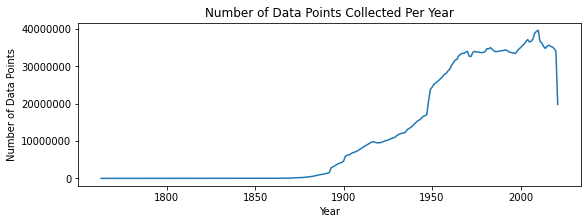

In [14]:
plt.figure(figsize=(9, 3))
plt.plot(years, sample_points);
plt.title("Number of Data Points Collected Per Year")
plt.ticklabel_format(style='plain')
plt.xlabel("Year")
plt.ylabel("Number of Data Points");

We can also do an analysis per country, such as US.

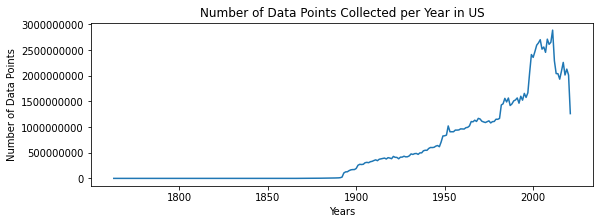

In [15]:
plt.figure(figsize=(9, 3))
station_data_freq['US'].T.plot();
plt.title("Number of Data Points Collected per Year in US")
plt.ticklabel_format(style='plain')
plt.xlabel("Years")
plt.ylabel("Number of Data Points");

We can observe what type or element of data has been recorded using simple dataframe calls. Here we plot the top 25 most popular ones, most popular being the precipitation.

Text(0, 0.5, 'Count')

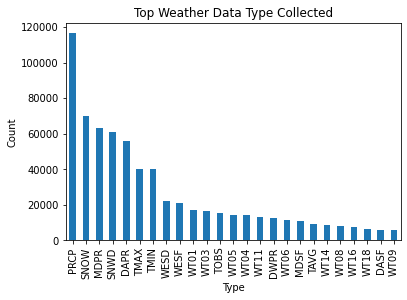

In [16]:
inventory["ELEMENT"].value_counts().head(25).plot(kind="bar");
plt.title("Top Weather Data Type Collected")
plt.xlabel("Type")
plt.ylabel("Count")

Conveniently, we have longitude and latitude provided to show the spatial frequency of where data is being collected, which reveals a very similar outline of our earth!

We see that more developed countries and cities have higher spatial frequency of weather stations. It's also interesting to observe that inhabitable areas of land have lower or no weather stations. Some developed countries also have less scattered weather stations, such as China and some areas of Europe. It could be because of data that NOAA doesn't have control over in collecting or laws that prevent countries sharing such data.

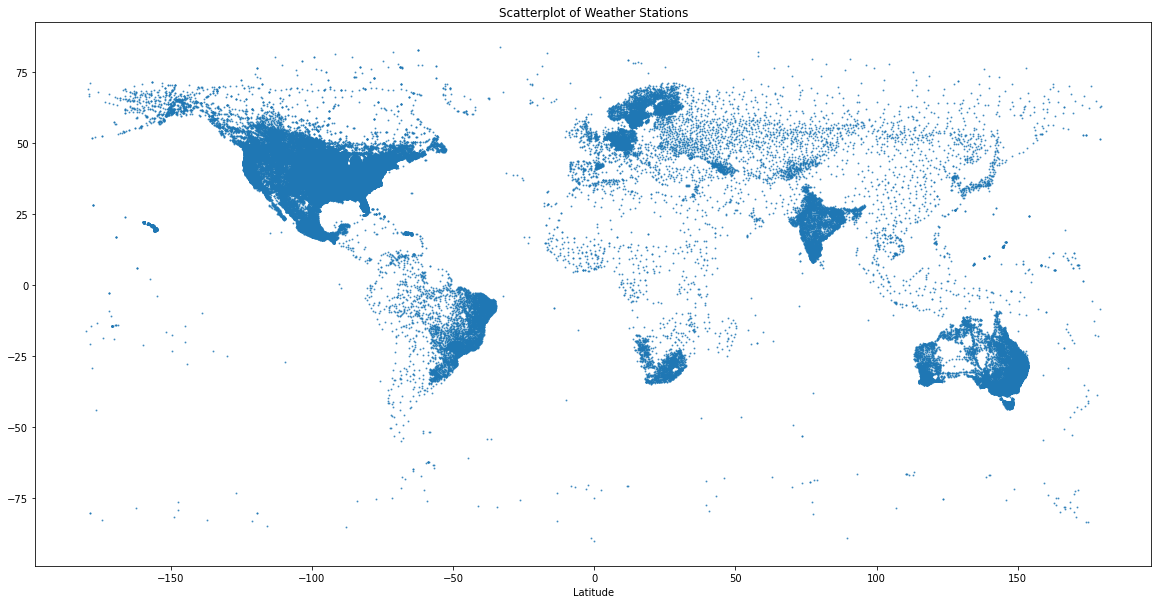

In [17]:
plt.figure(figsize=(20, 10))
plt.title("Scatterplot of Weather Stations")
plt.xlabel("Longitude")
plt.xlabel("Latitude")
plt.scatter(x=stations['LONGITUDE'], y=stations['LATITUDE'], s=0.9, alpha=0.7);

Although Matplotlib gives us a simple API to quickly plot graphs, with Modin seamlessly integrating with it, more advanced plotting libraries such as Plotly can give us better visualizations. We can use the metadata in our dataframes to our advantage and plot highly interpretable and visual plots on top of geographical maps provided by OpenStreetMap. First let's replicate the simple spatial plot we did in Matplotlib to Plotly on an overlay of the map. Notice that we now have to convert our Modin dataframe back to Pandas to make it compatible with Plotly.

Due to data constraints, we will save it to a file called `station_density.html`. Again, Plotly is also not scalable, so it'll run on the head node. We wish to see more scalable visualization tools for data science someday!

Once done running and writing locally, we can view it here: 

[station_density.html](station_density.html)

In [18]:
fig = px.density_mapbox(stations._to_pandas(), lat='LATITUDE', lon='LONGITUDE', radius=5,
                        center=dict(lat=0, lon=180), zoom=0,
                        mapbox_style="stamen-terrain")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("station_density.html")

## Modeling Weather by Spatial Locality within Ray Environment (NumS, XGBoost, Sklearn)
After exploratory data analysis, our next step is to answer or find another question to our problem and offer explanation and reasoning behind it, primarily through modeling. With NumS, it's possible to do generalized linear modeling (GLM) to give us predictions and modeling at scale, with high intuition and understandability of parameters. We can also use NumS's experimental package of XGBoost to directly run XGBoost off of a Modin dataframe, a popular library for gradient boosted decision trees. And lastly, we can use SKlearn's Random Forest model with Ray by replacing the joblib backend with Ray actors.

Before we start, let's revisit a few issues we discovered during our exploratory data analysis. We know that inhabitable areas have little to no stations or data recorded, as well as some developed countries where data might not be readily available to NOAA. Is it possible to "learn" the features of the earth's geographical location and time to predict weather?

Let's first create a design matrix. Here, we will make a design matrix that one hot encodes the day to the day of the year, precipitation, temperature maximum, temperature minimum, temperature average, temperature range, latitude, longitude, and elevation.

In [19]:
test_elements = ["PRCP", "TMAX", "TMIN"]
data = design_matrix(years[-1:], test_elements, target=["PRCP"], convert_nps=False, local=local)
data = data[data["PRCP"] >= 0] #remove any negative/invalid data
data.head()

/home/brian/external/anaconda3/envs/aws-asdi/lib/python3.7/site-packages/modin/pandas/dataframe.py:150: UserWarning:

Distributing <class 'NoneType'> object. This may take some time.



  0%|          | 0/1 [00:00<?, ?it/s]

/home/brian/external/anaconda3/envs/aws-asdi/lib/python3.7/site-packages/modin/error_message.py:38: UserWarning:

`pivot_table` implementation has mismatches with pandas:
Order of columns could be different from pandas.



,ID,YEAR/MONTH/DAY,PRCP,TMAX,TMIN,LATITUDE,LONGITUDE,ELEVATION,AVG,RANGE
3,AE000041196,4,0.0,27.3,12.0,25.333,55.517,34.0,19.65,15.3
4,AE000041196,5,0.0,27.2,9.7,25.333,55.517,34.0,18.45,17.5
5,AE000041196,6,0.0,27.3,10.9,25.333,55.517,34.0,19.10,16.4
7,AE000041196,8,0.0,26.1,10.8,25.333,55.517,34.0,18.45,15.3
8,AE000041196,9,0.0,25.5,7.4,25.333,55.517,34.0,16.45,18.1


Using our previous techniques of EDA, we can also plot the graph. Let's take a day such as Januaary 1st, 2020 and plot the precipitation onto our map.

In [20]:
plot = design_matrix([2020], test_elements, target=["PRCP"], convert_nps=False, local=local)
plot = plot[plot["PRCP"] >= 0]
plot = plot[(plot["YEAR/MONTH/DAY"] == 1) & (plot["PRCP"] > 0)]
fig = go.Figure(go.Densitymapbox(lat=plot.LATITUDE, lon=plot.LONGITUDE, z=plot.PRCP,
                                 radius=10))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("prcp_dmatrix_density.html")

/home/brian/external/anaconda3/envs/aws-asdi/lib/python3.7/site-packages/modin/pandas/dataframe.py:150: UserWarning:

Distributing <class 'NoneType'> object. This may take some time.



  0%|          | 0/1 [00:00<?, ?it/s]

Next, we can perform a train-test split on the data. Because the data is so big, and there are multiple logs of repetitive data, doing a train-test split on raw data logs might take too long. Instead, we will train-test split based on station ID. This allows us to hold out a few stations for training and do cross-validation to evaluate whether our model has "learned" the weather patterns of other stations from spatial locality.

In [21]:
X_train, X_test, y_train, y_test = design_matrix_to_train_test(data)

Using driver node ip as head node.
head node 10.0.0.4
total cpus 32.0
device_grid (0, 0) 0=node:10.0.0.4/cpu:1


We can start off with something simple, such as Linear Regression to see if any of the features have a linear relationship. NumS provides a Sklearn-like API through the `nums.models` package.

In [22]:
from nums.models.glms import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

In [23]:
training_results = model.predict(X_train)
test_results = model.predict(X_test)

print("Training RMSE:", rmse(training_results, y_train))
print("Testing RMSE", rmse(test_results, y_test))

Training RMSE: 73.39245851106266
Testing RMSE 73.58339805745203


As we can see from the RMSE values, they do not look promising. We can also use Logistic Regression to model the precipitation in our earth. First, it'll require us to change our prediciton values to prediction labels for binary classification.

In [24]:
# convert y_train and y_test to binary labels
y_train_block_shape = y_train.block_shape
y_train = y_train.get()
y_train[y_train > 0] = 1.0
y_train = nps.array(y_train)
y_train = y_train.reshape(block_shape=y_train_block_shape)


y_test_block_shape = y_test.block_shape
y_test = y_test.get()
y_test[y_test > 0] = 1.0
y_test = nps.array(y_test)
y_test = y_test.reshape(block_shape=y_test_block_shape)

We will also see that if our matrix is singular. As a fix, we will add a small mask of floating point numbers to make it invertible without drastically changing the numbers of our design matrix.

In [25]:
from nums.models.glms import LogisticRegression

# since matrix could be singular, a mask is added on to X_train to help invert it
mask = nps.random.rand(X_train.shape[0], X_train.shape[1]) * 0.00001

model = LogisticRegression()
model.fit(X_train + mask, y_train)

In [26]:
training_results = model.predict(X_train)
test_results = model.predict(X_test)

print("Training Accuracy:", (nps.sum(training_results == y_train) / y_train.shape[0]).get())
print("Test Accuracy:", (nps.sum(test_results == y_test) / y_test.shape[0]).get())

Training Accuracy: 0.7174379092095801
Test Accuracy: 0.7238512165180382


Another highly interpretable model we can use is decision trees. But the problem with that is that it fails to perform at scale. It's a recursive tree algorithm, which are not embarassingly parallel. But we can use boosting methods to parallelize it, such as XGBoost. NumS has an experimental package, which allows you to directly run XGBoost off of our NumS design matrices. This is a really popular and high performing model used in Kaggle competitions.

In [27]:
# TODO: Find parameter that fixes thrashing
"""
from nums.experimental.nums_xgb import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
print(model.predict(X_test).get())
"""

'\nfrom nums.experimental.nums_xgb import XGBClassifier\nmodel = XGBClassifier()\nmodel.fit(X_train, y_train)\nprint(model.predict(X_test).get())\n'

In [28]:
#(nps.sum(model.predict(X_test) == y_test) / y_test.shape[0]).get()

In [29]:
"""
# TODO: Figure out how to interpret model visually through NumS
y_result = prediction[1].to_numpy()
y_result[y_result >= 0.5] = 1
y_result[y_result < 0.5] = 0
np.sum(y_result == y_test.get()) / y_result.shape[0]
"""

'\n# TODO: Figure out how to interpret model visually through NumS\ny_result = prediction[1].to_numpy()\ny_result[y_result >= 0.5] = 1\ny_result[y_result < 0.5] = 0\nnp.sum(y_result == y_test.get()) / y_result.shape[0]\n'

Rather than treating the model as a black box, we can plot the decisions the model has made to intuitively understand which features contributed to the prediction.

In [30]:
"""
from xgboost import plot_tree

plot_tree(model, num_trees=4, feature_names=['YEAR/MONTH/DAY', 'TMAX', 'TMIN','AVG', 'RANGE', 'LATITUDE', 'LONGITUDE', 'ELEVATION'])
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('xgboost_tree.png')
"""

"\nfrom xgboost import plot_tree\n\nplot_tree(model, num_trees=4, feature_names=['YEAR/MONTH/DAY', 'TMAX', 'TMIN','AVG', 'RANGE', 'LATITUDE', 'LONGITUDE', 'ELEVATION'])\nfig = plt.gcf()\nfig.set_size_inches(150, 100)\nfig.savefig('xgboost_tree.png')\n"

In [31]:
test_elements = ["PRCP", "TMAX", "TMIN"]
data = design_matrix(years[-1:], test_elements, target=["PRCP"], convert_nps=False, local=local)
data = data[data["PRCP"] >= 0] #remove any negative/invalid data

  0%|          | 0/1 [00:00<?, ?it/s]

We can also perform random forests, another embarassingly parallel algorithm that can utilize running decision trees per Ray Actors across a cluster.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import joblib
from ray.util.joblib import register_ray
register_ray()

with joblib.parallel_backend('ray'):
    model = RandomForestClassifier(max_depth=4)
    model.fit(X_train.get(), y_train.get())

2021-09-17 17:20:41,430	WARNING pool.py:470 -- The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.


In [33]:
with joblib.parallel_backend('ray'):
    print("Training Accuracy:", model.score(X_train.get(), y_train.get()))
    print("Test Accuracy:", model.score(X_test.get(), y_test.get()))

Training Accuracy: 0.7238986915518352
Test Accuracy: 0.727966665404812


Like we did for gradient boosted decision trees, we cal also plot a single decision tree that random forest has trained and predicted on. Sklearn's plotting function also provided more interpretability, so we can figure out what the splitting rule was at each tree node. Here, we'll plot the 1st decision tree in our random forest model.

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=2.477480677426688.
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'ST

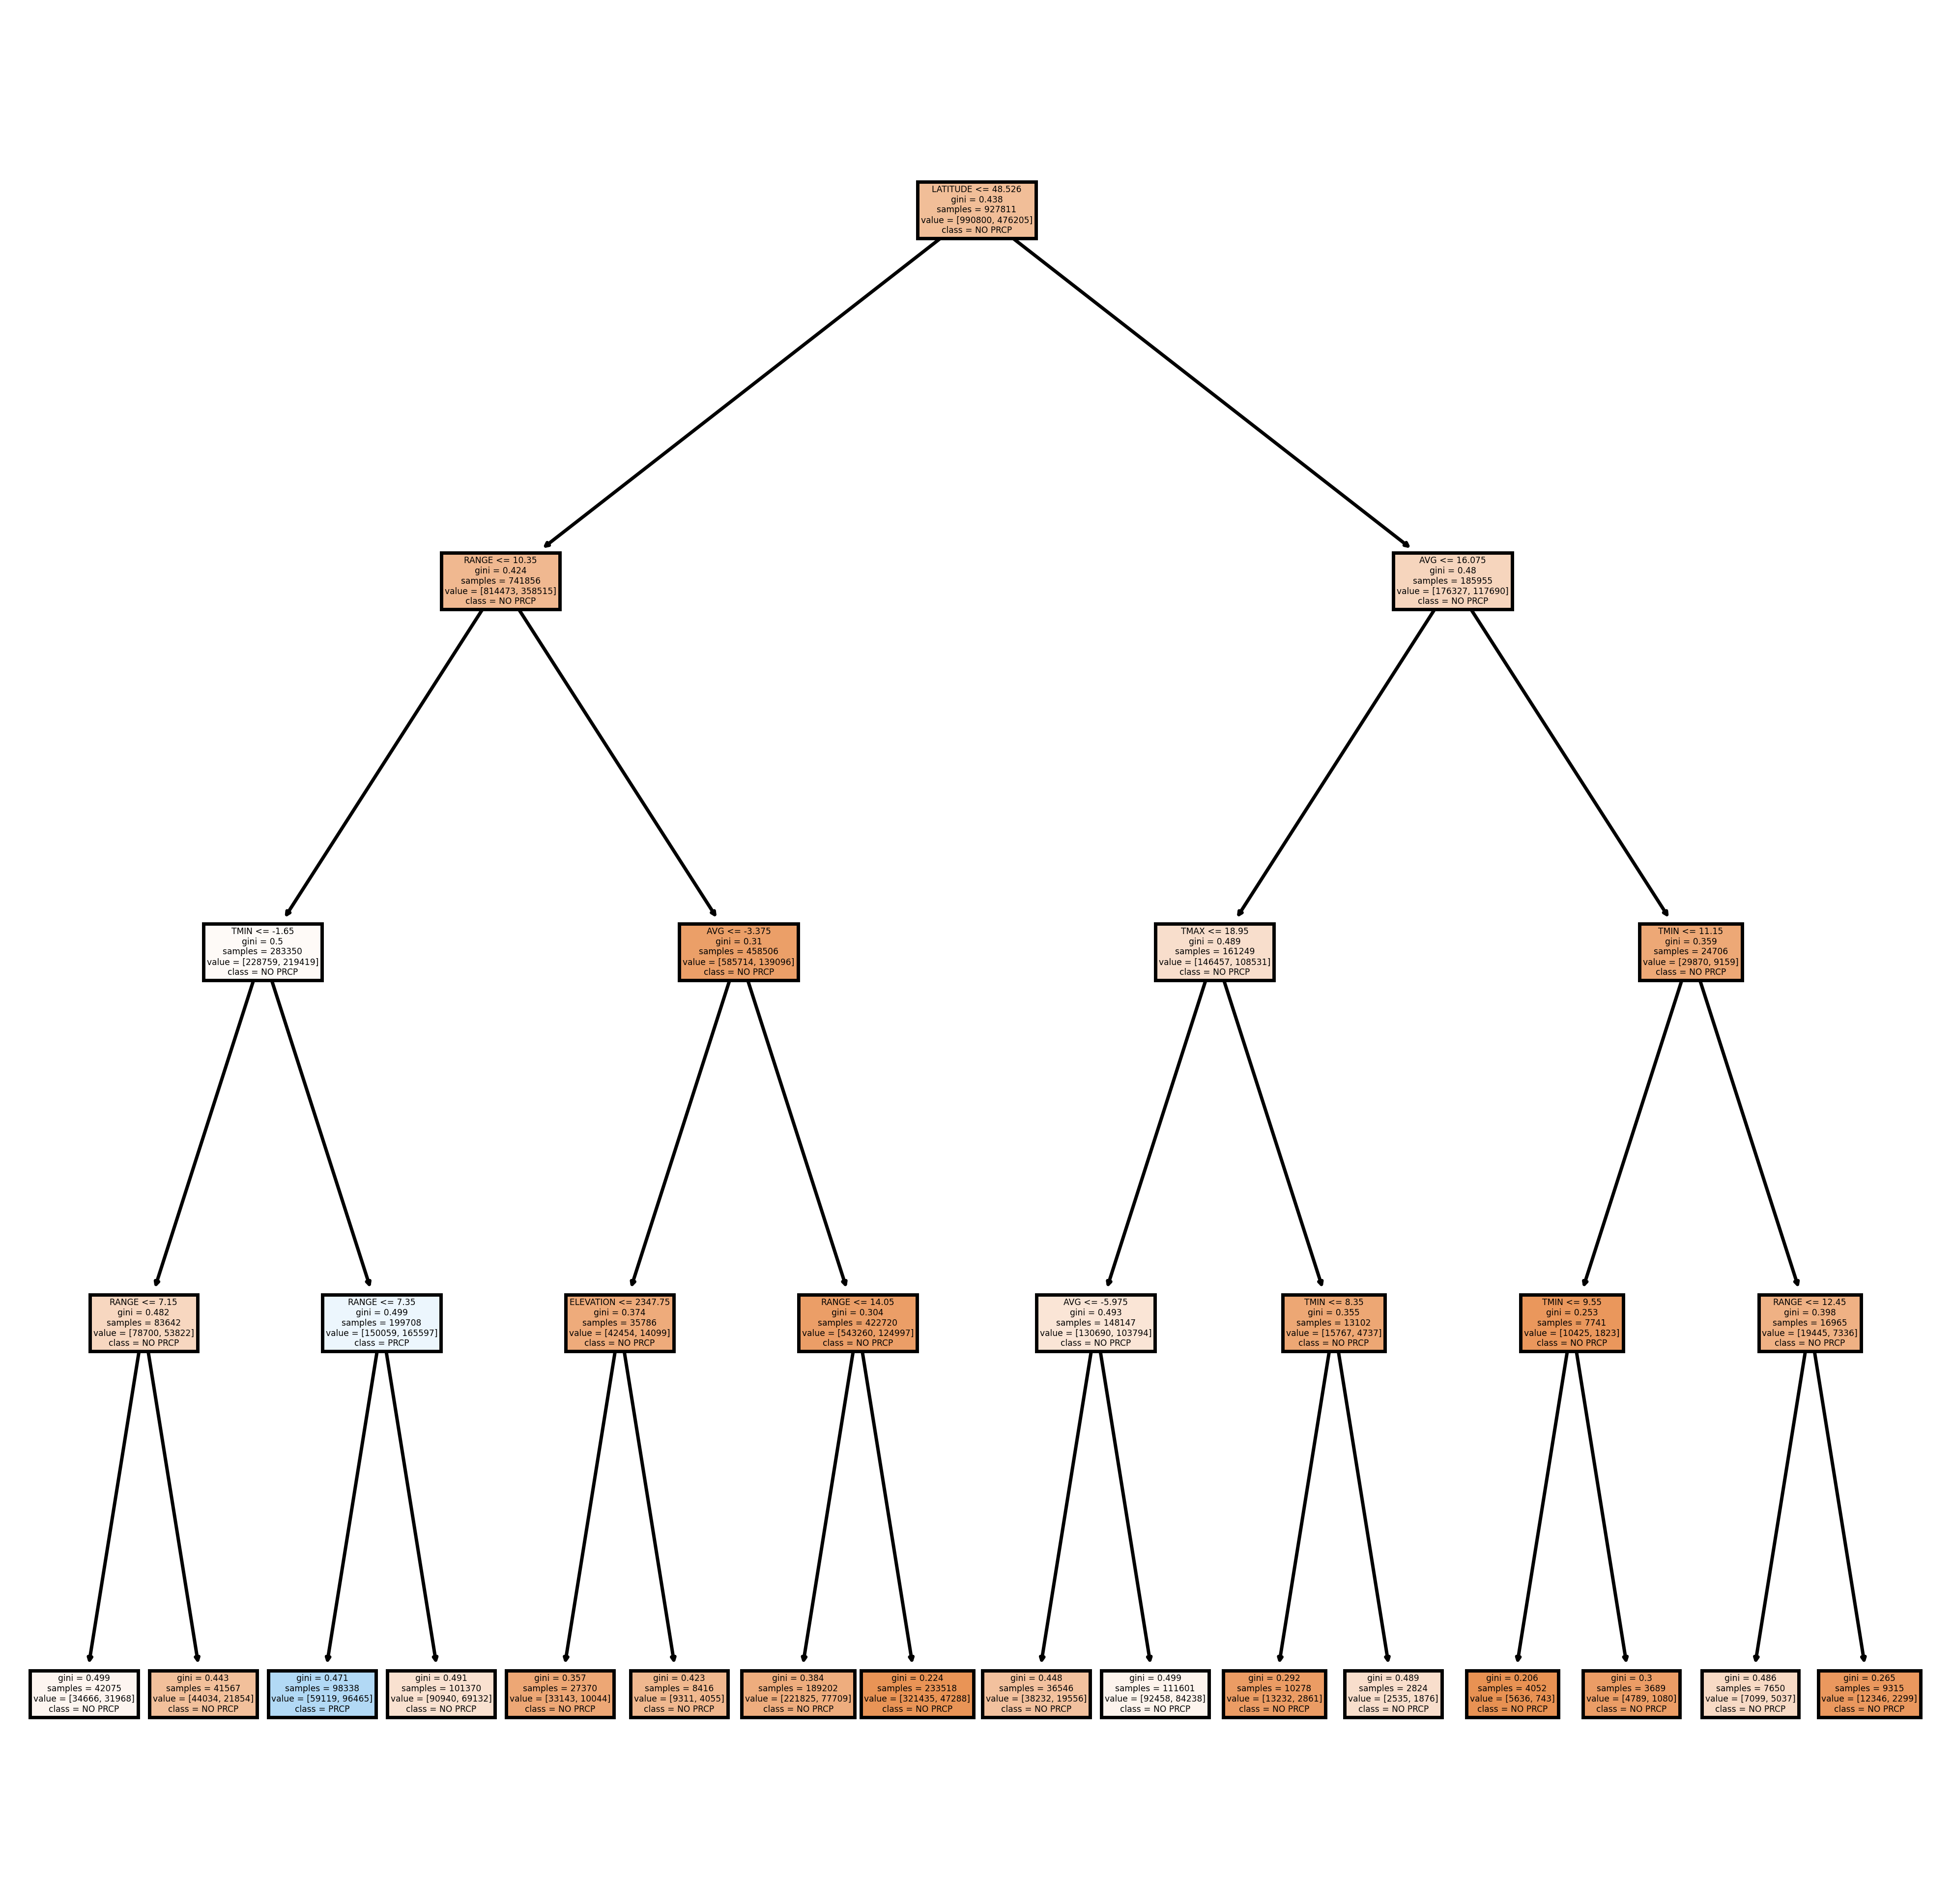

In [34]:
columns = ['YEAR/MONTH/DAY', 'TMAX', 'TMIN','AVG', 'RANGE', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), dpi=500);

tree.plot_tree(model.estimators_[0], feature_names=columns, class_names=["NO PRCP", "PRCP"], filled=True);
fig.savefig('rf_decision_tree_prcp.png', dpi=500, transparent=False)

Recall the question we asked earlier, if we can "learn" weather patterns as well, especially in places where it is inhabitable and not much weather stations availiable. Could we generalize these sparse areas of data? The features of our previous design matrix involved day of year, precipitation, temperature maximum, temperature minimum, temperature average, temperature range, latitude, longitude, and elevation. But looking at new/unknown locations limits the amount of features we can deal with. As a starting point, we can create a meshgrid of longitudes and latitudes. Then train and predict precipitation based purely by location and day of year. We lose some motivating features such as temperature and elevation. Given terrain data for elevation, we could easily merge it via Modin and maybe get better predictions. Other big datasets that could be beneficial in predicting weather at unknown locations. There are variety of other datasets provided by [NOAA on AWS Amazon Sustainability Data Initiative](https://registry.opendata.aws/) such as sea data, terrain data, atmospheric data, severe weather data, and much more. 

In [35]:
x = nps.linspace(-90, 90, 1000).get()
y = nps.linspace(-180, 180, 1000).get()

geo_data = []

for i in tqdm(range(x.shape[0])):
    for j in range(y.shape[0]):
        geo_data.append((x[i], y[j]))
        
new_location_df = pd.DataFrame(geo_data, columns=["lat", "lon"])
new_location_df["day"] = 1
new_location_df = new_location_df.reindex(columns=['day', 'lat', 'lon'])
location_grid = new_location_df.astype(float).to_numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/brian/external/anaconda3/envs/aws-asdi/lib/python3.7/site-packages/modin/pandas/dataframe.py:150: UserWarning:

Distributing <class 'list'> object. This may take some time.



In [36]:
test_elements = ["PRCP", "TMAX", "TMIN"]
data = design_matrix(years[-1:], test_elements, target=["PRCP"], convert_nps=False, local=local)
data = data[data["PRCP"] >= 0]
df = data[["YEAR/MONTH/DAY", "LATITUDE", "LONGITUDE", "PRCP"]]
df = df[df["YEAR/MONTH/DAY"] == 1]
X = df[["YEAR/MONTH/DAY", "LATITUDE", "LONGITUDE"]].to_numpy()
y = df["PRCP"].to_numpy()
y[y > 0] = 1

/home/brian/external/anaconda3/envs/aws-asdi/lib/python3.7/site-packages/modin/pandas/dataframe.py:150: UserWarning:

Distributing <class 'NoneType'> object. This may take some time.



  0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
with joblib.parallel_backend('ray'):
    model = RandomForestClassifier(max_depth=3)
    model.fit(X, y)
    print("Training Accuracy:", model.score(X, y))

Training Accuracy: 0.7700034242666363


In [38]:
# Predict new locations
with joblib.parallel_backend('ray'):
    prcp = model.predict(location_grid)
new_location_df["prcp"] = prcp
new_location_df = new_location_df[new_location_df["prcp"] == 1]
new_location_df

,day,lat,lon,prcp
233,1,-90.0,-96.036036,1.0
234,1,-90.0,-95.675676,1.0
235,1,-90.0,-95.315315,1.0
236,1,-90.0,-94.954955,1.0
237,1,-90.0,-94.594595,1.0
...,...,...,...,...
999995,1,90.0,178.558559,1.0
999996,1,90.0,178.918919,1.0
999997,1,90.0,179.279279,1.0
999998,1,90.0,179.639640,1.0


In [39]:
fig = go.Figure(go.Densitymapbox(lon=new_location_df.lon, lat=new_location_df.lat, radius=5))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("new_locations_prcp.html")

In [40]:
actual = data[["YEAR/MONTH/DAY", "LATITUDE", "LONGITUDE", "PRCP"]]
actual = actual[(actual["YEAR/MONTH/DAY"] == 1) & (actual["PRCP"] > 0)]
actual

,YEAR/MONTH/DAY,LATITUDE,LONGITUDE,PRCP
16088,1,-14.3306,-170.7136,53.0
32211,1,-53.7780,-67.7490,3.0
32651,1,-16.2880,149.9650,81.0
34031,1,-14.2964,126.6453,312.0
40384,1,-18.6844,121.7803,62.0
...,...,...,...,...
6530934,1,62.7369,-141.2083,6.0
6545815,1,17.7028,-64.8056,13.0
6546040,1,18.3331,-64.9667,3.0
6546471,1,-22.5670,17.1000,71.0


In [41]:
fig = go.Figure(go.Densitymapbox(lon=actual.LONGITUDE, lat=actual.LATITUDE,
                                 radius=5))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("actual_prcp.html")

## Modeling Weather by Temporal Locality with Time Series (NumS)
Next, we can model and predict our data to figure out what it has to do with time. Weather often has seasonal patterns. Let's focus in on a specific weather station for this tutorial, which will be station USC00040693. This weather station is located on UC Berkeley campus [(Google Maps)](https://www.google.com/maps/place/37°52'27.8%22N+122°15'38.2%22W/@37.8744024,-122.2618614,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x0!8m2!3d37.8744!4d-122.2606). Through Modin, we can quickly parse out what type of data this weather station records. Let's revisit our exploratory data analysis skills to unreveal what the data is able to provide us in terms of time.

In [42]:
inventory[inventory["ID"] == 'USC00040693']

,ID,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
389285,USC00040693,37.8744,-122.2606,TMAX,1893,2021
389286,USC00040693,37.8744,-122.2606,TMIN,1893,2021
389287,USC00040693,37.8744,-122.2606,TOBS,1901,2020
389288,USC00040693,37.8744,-122.2606,PRCP,1893,2021
389289,USC00040693,37.8744,-122.2606,SNOW,1899,2010
389290,USC00040693,37.8744,-122.2606,SNWD,1913,2010
389291,USC00040693,37.8744,-122.2606,DAPR,1953,2012
389292,USC00040693,37.8744,-122.2606,MDPR,1953,2012
389293,USC00040693,37.8744,-122.2606,WT01,1893,1997
389294,USC00040693,37.8744,-122.2606,WT03,1915,1988


In [43]:
berkeley_weather_elements = inventory[inventory["ID"] == 'USC00040693'][["ELEMENT", "FIRSTYEAR", "LASTYEAR"]]
berkeley_weather_elements = berkeley_weather_elements[berkeley_weather_elements["ELEMENT"].isin(["TMAX", "TMIN", "PRCP"])] #override to save time
berkeley_time_series = {}

for _, rows in berkeley_weather_elements.iterrows():
    element, firstyear, lastyear = rows
    berkeley_time_series[element] = df_filter_vector('USC00040693', element, local=local, custom_years=(lastyear-20, lastyear - 1)) #only grabbing the last 20 years for effiency

/home/brian/external/anaconda3/envs/aws-asdi/lib/python3.7/site-packages/modin/pandas/dataframe.py:150: UserWarning:

Distributing <class 'NoneType'> object. This may take some time.



  0%|          | 0/20 [00:00<?, ?it/s]

/home/brian/external/anaconda3/envs/aws-asdi/lib/python3.7/site-packages/modin/pandas/dataframe.py:566: UserWarning:

Due to https://github.com/pandas-dev/pandas/issues/35092, Pandas ignores sort=False; Modin correctly does not sort.



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

We can plot the data in the last 3 years (Plotting all of the data will take a long time due to the bottleneck of Matplotlib's serial performance).

Text(0.5, 1.0, 'Precipitation')

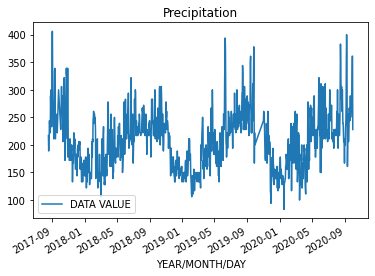

In [66]:
berkeley_time_series["TMAX"].tail(365 * 3).plot();
plt.title("Temperature Maximum in Berkeley")
plt.y

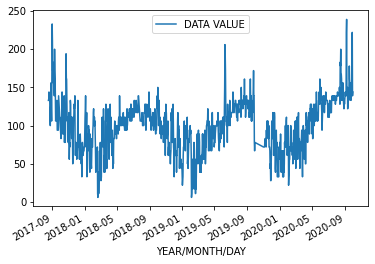

In [45]:
berkeley_time_series["TMIN"].tail(365 * 3).plot();

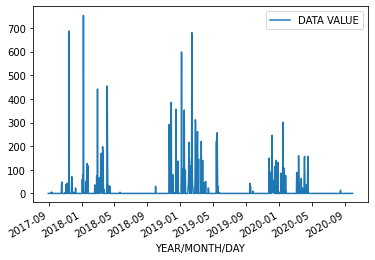

In [46]:
berkeley_time_series["PRCP"].tail(365 * 3).plot();

We can start modeling with simple linear regression. Although it wont give us the most accurate model and predictions due to weather data being seasonal and sinusoidal, it is at least a good starting point and baseline for other model's performance and accuracy.

In [47]:
from nums.models.glms import LinearRegression
y_train = berkeley_time_series["TMIN"].iloc[-4000:-1000].to_numpy().reshape(-1) 
y_test = berkeley_time_series["TMIN"].iloc[-1000:].to_numpy().reshape(-1) 

#convert to NumS arrays, assigning to y since we want X to be time, y to be TMIN (data value)
y_train = nps.array(y_train)
y_test = nps.array(y_test)

In [49]:
X_train = nps.arange(0, y_train.shape[0], 1).reshape(-1, 1).astype(float)
X_test = nps.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0], 1).reshape(-1, 1).astype(float)

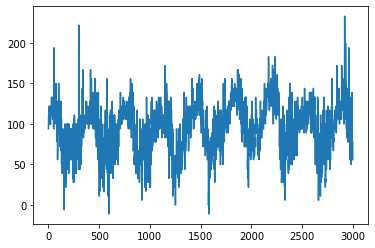

In [50]:
plt.plot(X_train.get(), y_train.get());

In [51]:
model = LinearRegression()
model.fit(X_train, y_train)

print("Training RMSE:", rmse(y_train, model.predict(X_train)))
print("Test RMSE:", rmse(y_test, model.predict(X_test)))

Training RMSE: 30.536243170190698
Test RMSE: 33.47685636485453


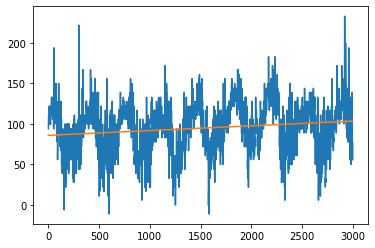

In [52]:
plt.plot(X_train.get(), y_train.get())
plt.plot(X_train.get(), model.predict(X_train).get());

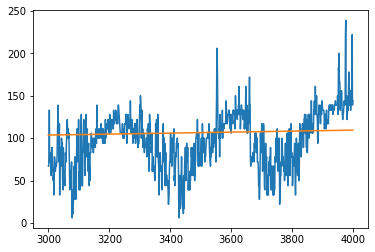

In [53]:
plt.plot(X_test.get(), y_test.get())
plt.plot(X_test.get(), model.predict(X_test).get());

Model also reveals to use that there is only a slight positive trend in data with the slope obtained from, indicating that there is indeed climate change.

In [54]:
model._beta.get()

array([0.00586346])

We see that temperature has a sinusoudal pattern. Before doing more modeling, let's stack all the years on top of each other to get a design matrix of temperature data where the rows are year, columns are day of year.

In [60]:
berkeley_tmax_design_matrix = design_matrix_time_series_stack('USC00040693', 'TMAX', years, local=local)

  0%|          | 0/10 [00:00<?, ?it/s]

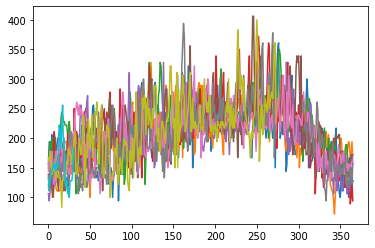

In [61]:
for i in range(berkeley_tmax_design_matrix.shape[0]):
    plt.plot(berkeley_tmax_design_matrix[i].get());

With this design matrix, we can run Principal Component Analysis (PCA) with NumS's SVD solver to observe abnormalities in the data. Ideally, it should be reducable to one dimension since all the rows should be nearly identical, with some variance, as shown in the scree plot.

In [62]:
from nums.core import linalg
from nums.core import application_manager
nps_app_inst = application_manager.instance()

U, S, V = linalg.svd(nps_app_inst, nps.nan_to_num(berkeley_tmax_design_matrix.T))

/home/brian/external/anaconda3/envs/aws-asdi/lib/python3.7/site-packages/nums/numpy/api.py:50: RuntimeWarning:

Operation nan_to_num not implemented, falling back to NumPy. If this is too slow or failing, please open an issue on GitHub.



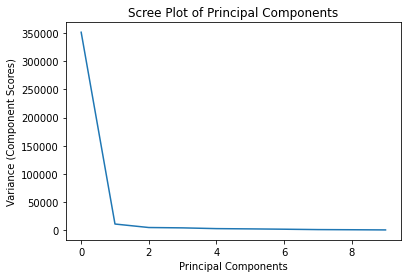

In [63]:
plt.xlabel("Principal Components")
plt.ylabel("Variance (Component Scores)")
plt.title("Scree Plot of Principal Components")
plt.plot(S[:25].get() ** 2 / U.shape[0])

But when plotting the projection vectors, we observe something different. We see that near day 50, there is a sharp spike. This is usually the time that leap days occur, indicating that there is missing data or inconsistesies. We will see how this affects us later. (***TODO: fix after time series model are done***)

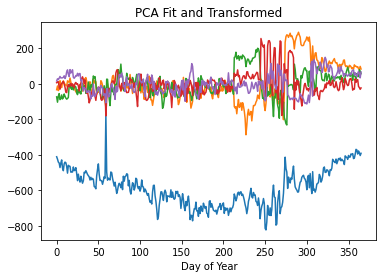

In [64]:
n = 5
reduced = U[:, :n] @ nps.diag(S[:n])
for i in range(n):
    plt.plot(reduced[:, i].get())
plt.title("PCA Fit and Transformed")
plt.xlabel("Day of Year");

In [67]:
# TODO: (Daniel) Factor in autoregressive models once done.

## End
To stop and shutdown the notebook properly, we can free memory and shutdown Ray.

In [68]:
del dfs

In [69]:
!ray stop

2021-09-17 18:24:54,317	WARNING worker.py:1215 -- The autoscaler failed with the following error:
Terminated with signal 15
  File "/home/brian/external/anaconda3/envs/aws-asdi/lib/python3.7/site-packages/ray/autoscaler/_private/monitor.py", line 423, in <module>
    monitor.run()
  File "/home/brian/external/anaconda3/envs/aws-asdi/lib/python3.7/site-packages/ray/autoscaler/_private/monitor.py", line 324, in run
    self._run()
  File "/home/brian/external/anaconda3/envs/aws-asdi/lib/python3.7/site-packages/ray/autoscaler/_private/monitor.py", line 241, in _run
    time.sleep(AUTOSCALER_UPDATE_INTERVAL_S)

2021-09-17 18:24:54,420	ERROR import_thread.py:88 -- ImportThread: Connection closed by server.
2021-09-17 18:24:54,420	ERROR worker.py:1217 -- listen_error_messages_raylet: Connection closed by server.
2021-09-17 18:24:54,421	ERROR worker.py:475 -- print_logs: Connection closed by server.


Stopped all 53 Ray processes.
